# CAIM Lab Session 5: Duplicate detection using simhash

In this session you will:

- implement the simhashing algorithm
- apply it to the `arxiv` abstracts to detect near duplicates among documents in this index

## 1. Simhash-based near-duplicate detection algorithm

We depart from an indexed corpus, namely the one that we have used in previous sessions that contains 58102 abstracts from the
scientific [arXiv.org](https://arxiv.org) repository. The following pseudocode uses $k,m$ as the usual parameters for lsh (locality sensitive hashing)
scheme for gap amplification (repetition of $m$ lsh tables, using $k$ projections each).

  1. For each word $t$ in the vocabulary $V$ we generate $b = k\times m$ random $\pm 1$ signs:
      - generate a unique hash (bitstring) $h_t$ of size $b$
      - let $h'_t$ be the hash above but replacing each 0 with -1.
  
  2. We view each document as a tf-idf weighted sum of its terms. Thus, to hash a document, we sum the weighted contributions of all its terms. Specifically, for each document in our corpus represented by list of non-zero entries $t, w_t$:
      - compute $simhash(d)$ as sum $\sum_t h'_t * w_t$. 
      - convert $simhash(d)$ to bit vector using the sign of entries (positive entries become 1, negative ones become 0)
  
  3. Slice simhashes into $m$ chunks of $k$ bits
     - for each $k$-bit chunk:
        - place the document into the bucket given by the chunk in the appropriate table. Note that we may identify each chunk with an integer index between 0 and 2^k - 1.
  
  4. Similar documents will likely fall on the same side of many hyperplanes, and thus share one or more $k$-bit chunks. Thus, the potential duplicates are pairs of documents that fall into the same bucket in **at least one** hash table. Now we need to
     - compute cosine similarity among these potential duplicates, and
     - show pairs in decreasing cosine similarity order.


---

**Exercise 1:**  

As a little exercise, suppose that a document $d$ contains _two_ non-zero entries, which correspond to terms `bit` with tf-idf weight $0.4$ and `coin` with tf-idf weight $1.2$.
The md5 hash code for `bit` is 1111 and the md5 code for `coin` is 1001 (so $b=4$). Compute the binary simhash for this document with $k=4, m = 1$. (_Hint: result should be 1001_)

---


## 2. Hashing codes for terms in vocabulary

To make your life easier, we provide code for generating hash codes for the terms in the vocabulary.
The given function takes as input the size of the hash, as well as the term itself.

We use a fast deterministic hash (MD5) to get repeatable pseudo-random bits. Even though it is actually deterministic, we assume that in practice its output behaviour is sufficiently similar to that of a truly random hash function.

In [1]:
import hashlib

def _termhash(x : str, b : int) -> str:
    """returns bitstring of size b based on md5 algorithm"""
    assert b <= 128, 'this encoding scheme supports hashes of length at most 128; try smaller b'
    h = hashlib.md5(x.encode('utf8')).digest()
    return ''.join(format(byte, '08b') for byte in h)[:b]

for w in ['bit', 'coin', 'hola que tal']:
    print(f'hash.md5({w}) = {_termhash(w, 4)}')


hash.md5(bit) = 1111
hash.md5(coin) = 1001
hash.md5(hola que tal) = 0110


## 3. Loading tf-idf for the whole corpus

We provide the document-term matrix with normalized tf-idf weights with a sparse representation.
This is so that further code does not need to check for tf-idf weights against elasticsearch which is very slow.

Please download the corpus data from https://www.cs.upc.edu/~caim/05corpus.pkl and run the following cells to access the data.

In [2]:
import pickle
import os

fname = '05corpus.pkl'

with open(fname, 'rb') as f:
    corpus = pickle.load(f)

### have a look at the data

Loaded corpus with 58102 documents.
A few document ids are: ['10855', '25673', '2582', '3356', '39447', '44960', '47844', '48348', '57379', '9545']
Each document is a dictionary with term -> tf-idf weights, e.g. the first:
{'0.009': 0.07755241277245155, '0.03': 0.05390282783916337, '2.3': 0.05697594345388175, '3': 0.037520471487291714, '6': 0.06263176984143355, '8': 0.03381614985233684, 'aboard': 0.07470497254146928, 'abridged': 0.04658961411040711, 'absence': 0.04085137050637872, 'accretion': 0.07414988654879776, 'acquire': 0.05537897824225455, 'also': 0.009403647100788688, 'area': 0.03366260253470469, 'assembled': 0.05973338041851722, 'balmer': 0.06406254101592618, 'based': 0.011164937538935934, 'because': 0.027935714599668877, 'below': 0.03351983591805465, 'beta': 0.03894190337702212, 'bh': 0.1040037433192134, 'billion': 0.058133513533385535, 'black': 0.13542398044242593, 'break': 0.08983543335503444, 'brighter': 0.11244031312128727, 'central': 0.03126711538871353, 'characterised': 

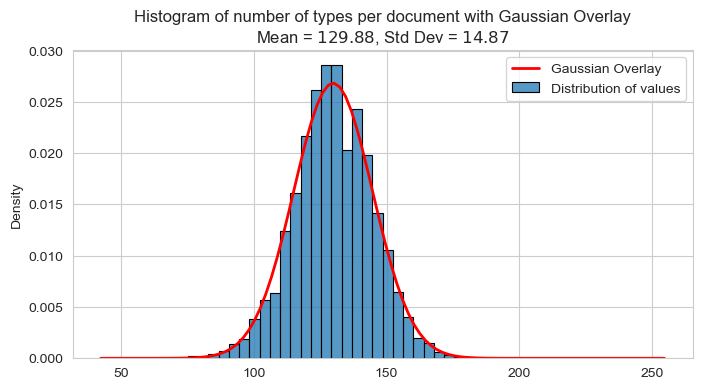

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import random

# show contents

print(f"Loaded corpus with {len(corpus)} documents.")
all_document_ids = list(corpus.keys())
print(f"A few document ids are: {sorted(random.sample(all_document_ids, 10))}")
print(f"Each document is a dictionary with term -> tf-idf weights, e.g. the first:")
print(corpus[all_document_ids[0]])

# obtain histogram with nr of terms in each document
values = [len(corpus[id]) for id in all_document_ids]
mu = np.mean(values)
sigma = np.std(values)
plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")
sns.histplot(values, bins=50, edgecolor='black', stat='density', label='Distribution of values')
plt.title(f'Histogram of number of types per document with Gaussian Overlay\nMean = ${mu:.2f}$, Std Dev = ${sigma:.2f}$', fontsize=12)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)

# Calculate the probability density function (PDF) for the x-values.
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma), 'red', linewidth=2, label='Gaussian Overlay')
plt.legend(); # Display the labels

## 4. Simhashing scheme and near-duplicate collection and verification

---

**Exercise 2:**  

Write the `simhash` function provided below. Make sure you understand that each bit of the simhash encodes which "side" the tf-idf document representation falls on a (pseudo-)random projection. 


---


In [4]:
from tqdm import tqdm

## constants
K = 18
M = 3
B = M*K

def _simhash(id, b):
    """
        id is the document id, b is the desired length of the simhash
        it should return a bitstring of length b as explained in the
        first section of the notebook
    """

    ## write your code
    return

## simhash stores all simhashes of the whole corpus in a dictionary
simhash = {id: _simhash(id, B) for id in tqdm(corpus)}

100%|██████████| 58102/58102 [00:00<00:00, 134327.55it/s]


---

**Exercise 3:**  

Based on simhashes, write code that places the documents in their corresponding lsh hash tables' buckets across $m$ repetitions. Once, the lsh hash tables have been
populated, find all potential near-duplicate candidate pairs. Check among all candidates their real cosine similarity and based on this determine true positives
(pairs of documents that are indeed similar and have collided in some table), and false positives (pairs of documents that are not similar but have collided in some table).
Compute speed of the method vs. false positives / true positives for different values of $m$ and $k$. Make sure that $k$ is not tiny (say greater than 10) if you want
the method to be fast.

---


## 5. Rules of delivery

- To be solved in _pairs_.

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.

- Turn the report to PDF. Make sure it has your names, date, and title. Include your code in your submission.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html); see date at the raco's submissions page.